# PAIRS TRADING WITH DBSCAN CLUSTERING

#### TRADEFORMERS GROUP

###### Nnamdi Olisaeloka - 19449534 
###### Ubeydullah Sark - 19456662 
###### Nursaiyn Bakyt - 19453647
###### Huang Zhen - 19449615
###### Dauren Zhaksylykov - 19453655

## Preparing the Environment

In [0]:
# Import the simfin package
!pip install simfin
import simfin as sf
from simfin.names import * #This package allows us to use capitalized easier-to-read versions of the column names in our data

# Import other relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Set your API-key for downloading data.
sf.set_api_key('free')

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

## Data Collection

In [0]:
# Load the annual Income Statements for all companies in the selected market.
df_income = sf.load_income(variant='annual', market='us')

# Load the annual cash flow data for all companies in the selected market.
df_cashflow = sf.load_cashflow(variant='annual', market='us')

# Load the daily share price data for all companies in the selected market.
df_prices = sf.load_shareprices(variant='daily', market='us')

Dataset "us-income-annual" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!


In [0]:
#We need to see what we have in the data, and if the indexes are at same range.
print("Income Statement:\n\n",df_income)
print("-"*100)
print("Cashflow Statement:\n\n", df_cashflow)
print("-"*100)
print("Share Prices Daily:\n\n", df_prices)

Income Statement:

                     SimFinId Currency  ...  Net Income Net Income (Common)
Ticker Report Date                     ...                                
A      2008-10-31      45846      USD  ...   693000000           693000000
       2009-10-31      45846      USD  ...   -31000000           -31000000
       2010-10-31      45846      USD  ...   684000000           684000000
       2011-10-31      45846      USD  ...  1012000000          1012000000
       2012-10-31      45846      USD  ...  1153000000          1153000000
...                      ...      ...  ...         ...                 ...
low    2014-02-28     186050      USD  ...  2286000000          2286000000
       2015-02-28     186050      USD  ...  2698000000          2698000000
       2016-02-29     186050      USD  ...  2546000000          2546000000
       2017-02-28     186050      USD  ...  3093000000          3093000000
       2018-02-28     186050      USD  ...  3447000000          3447000000

[149

## Features Engineering

In the next cellblock, we use reindex method from SimFin API. Reindex helps us to upsample our monthly data to daily data that matches share price data.

Normally our data is MultiIndex Pandas Dataframe, multinindexes being company tickers and date. After calculating most of our features, we find the mean values for each company dataset and drop the date index. 

In [0]:
#EBITDA
df_ebitda = df_income[OPERATING_INCOME].fillna(0) + df_cashflow[DEPR_AMOR].fillna(0)
df_ebitda_daily = sf.reindex(df_src=df_ebitda, df_target=df_prices, method='ffill')

#Net Profit Margin
df_net_margin = df_income[NET_INCOME] / df_income[REVENUE]
df_net_margin_daily = sf.reindex(df_src=df_net_margin, df_target=df_prices, method='ffill')

#EPS
df_eps = df_income[NET_INCOME] / df_income[SHARES_BASIC]
df_eps_daily = sf.reindex(df_src=df_eps, df_target=df_prices, method='ffill')

#PE Ratio
df_pe_ratio = df_prices[CLOSE] / df_eps_daily

#Market Cap
df_shares_daily = sf.reindex(df_src=df_income[SHARES_BASIC], df_target=df_prices, method='ffill')
df_market_cap = df_prices[CLOSE] * df_shares_daily

#Dividend Yield
df_dps = df_cashflow[DIVIDENDS_PAID]/ df_income[SHARES_BASIC]
df_dps_daily = sf.reindex(df_src=df_dps, df_target=df_prices, method='ffill')
df_div_yield = df_dps_daily / df_prices[CLOSE] 
df_div_yield.fillna(0,inplace=True)

#Combined Features
df_features = pd.concat([df_eps_daily,df_pe_ratio,df_market_cap,df_ebitda_daily,df_div_yield,
                         df_net_margin_daily],axis=1)
df_features.columns = ['EPS','PE RATIO','MARKET CAP','EBITDA','DIVIDEND YIELD','NET MARGIN']
df_features = df_features.groupby('Ticker').mean().dropna()

#Stock Returns
df_returns = df_prices[['Adj. Close']].pct_change().groupby('Ticker').apply(lambda x: x.iloc[1:].mean())

#Stock Volatility
df_volatility = df_prices[['Adj. Close']].pct_change().groupby('Ticker').apply(lambda x: x.iloc[1:].std())

df_features['RETURNS'] = df_returns
df_features['VOLATILITY'] = df_volatility

df_features

,EPS,PE RATIO,MARKET CAP,EBITDA,DIVIDEND YIELD,NET MARGIN,RETURNS,VOLATILITY
Ticker,,,,,,,,
A,1.826538,-10.030130,1.508452e+10,9.053553e+08,-0.004683,0.122540,0.000605,0.019782
AA,-0.653738,9.993184,7.223215e+09,1.774387e+09,0.000000,-0.014243,0.000674,0.026262
AAC,-0.933968,-8.345711,1.770793e+08,3.969000e+06,0.000000,-0.075841,-0.000490,0.048881
AAL,-1.232789,2.338983,1.413920e+10,3.545589e+09,-0.002974,0.005583,0.000756,0.043537
AAN,1.928701,16.941592,2.243321e+09,1.161913e+09,-0.001990,0.057353,0.000658,0.023895
...,...,...,...,...,...,...,...,...
ZTS,1.253076,43.956620,2.606620e+10,1.382679e+09,-0.005761,0.126808,0.000874,0.014324
ZUMZ,1.130091,22.305007,7.096517e+08,7.833814e+07,0.000000,0.047085,0.000566,0.035848
ZYNE,-3.044689,-3.994634,8.715995e+07,-2.181376e+07,0.000000,-inf,0.001176,0.077746


## DBSCAN Clustering

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [0]:
df_features.values[np.isfinite(df_features.values) == False] = 0

In [0]:
X = StandardScaler().fit_transform(df_features.values)

In [0]:
X.shape

(1806, 8)

In [0]:
def plotpls(graph,xname,yname):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    ax = fig.add_subplot(111)
    lines=ax.plot(graph)

    plt.ticklabel_format(useOffset=False,style='plain',axis='y')
    ax.set_ylabel(yname,fontsize=16)
    ax.set_xlabel(xname,fontsize=16)
    #ax.xaxis.set_ticks(xname)
    
    plt.grid(True)

    plt.show()

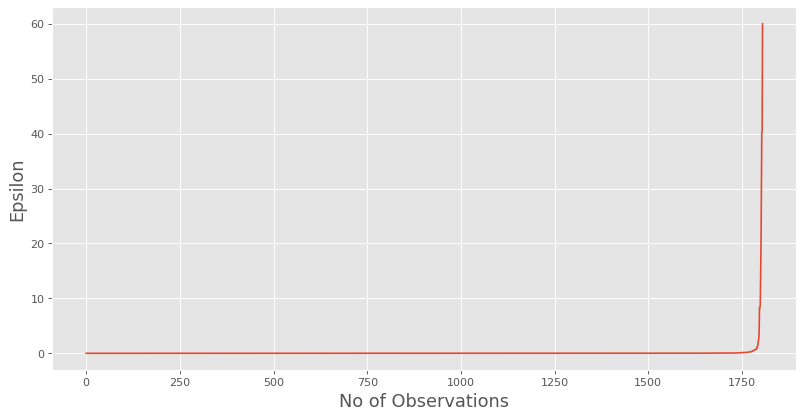

In [0]:
#choosing optimal 'epsilon' for DBSCAN clustering
nn = NearestNeighbors(n_neighbors=2)
nbrs = nn.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.plot(distances)
plotpls(distances,"No of Observations","Epsilon")

In [0]:
dbscan = DBSCAN(eps=0.01, min_samples=5)
print(dbscan)

dbscan.fit(X)
labels = dbscan.labels_
n_clusters_ = len(set(labels))
print("\nClusters discovered: %d" % n_clusters_)

labels = dbscan.labels_

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

Clusters discovered: 10


In [0]:
#Select clusters without noise
companies = df_features.index
df_clusters = pd.DataFrame({'Cluster': labels, 'Ticker': companies})
ticker_count_reduced = df_clusters[df_clusters['Cluster'] > 1]['Cluster'].value_counts()
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 7
Pairs to evaluate: 844


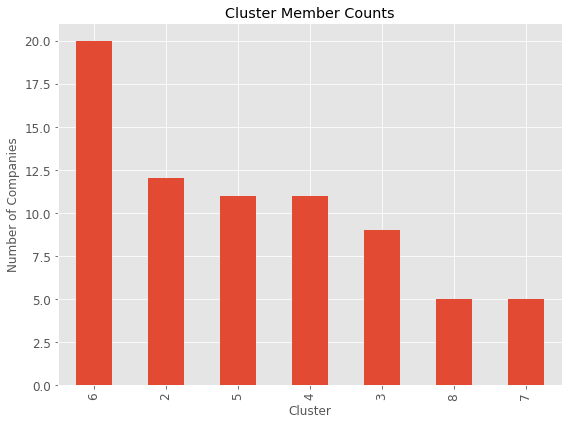

In [0]:
#Plot the number of stocks in each cluster
plt.figure(figsize=(8,6))
df_clusters['Cluster'].value_counts()[3:].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Companies')
plt.title('Cluster Member Counts')
plt.tick_params(labelsize=12)
plt.tight_layout()

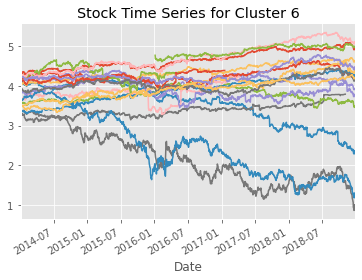

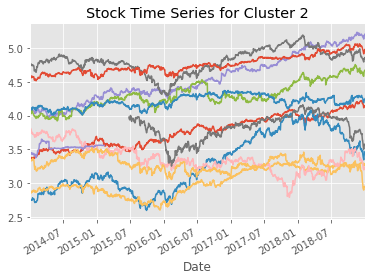

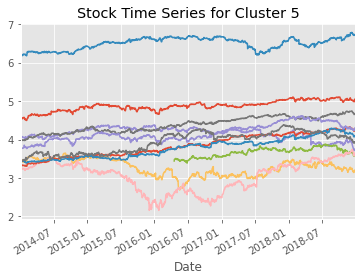

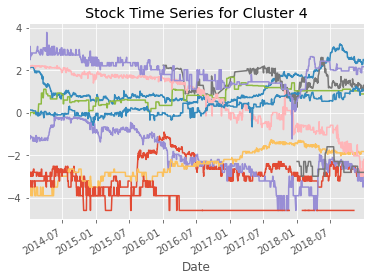

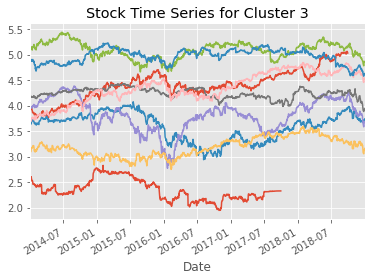

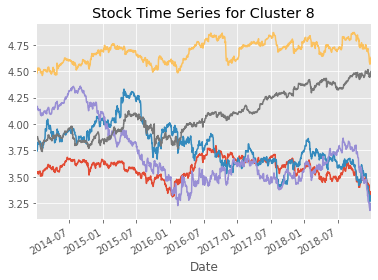

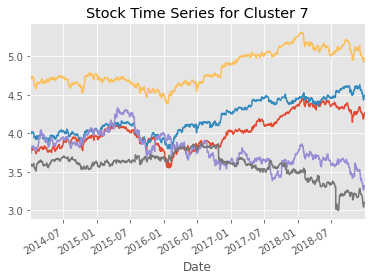

In [0]:
#Visualize price movement of stocks in the chosen clusters
cluster_list = list(ticker_count_reduced.index)

ticker_list = []
for c in cluster_list:
    tickers = list(df_clusters.groupby('Cluster').get_group(c).Ticker)
    ticker_list.append(tickers)
    
    for t in tickers:
        data = np.log(df_prices['Adj. Close'].loc[t].loc['2014-01-01':'2018-12-31'])
        data.plot(title='Stock Time Series for Cluster %d' % c)
    plt.show()

## Pairs Selection

In [0]:
#identify cointegrated pairs from clusters
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(cluster,significance,start_day,end_day):
    n = cluster.shape[0]
    keys = cluster['Ticker']
    pairs = []
    pvalues = []
    
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = df_prices['Adj. Close'].loc[keys.iloc[i]].loc[start_day:end_day].fillna(0)
            asset_2 = df_prices['Adj. Close'].loc[keys.iloc[j]].loc[start_day:end_day].fillna(0)
            if len(asset_1) == len(asset_2):
                result = coint(asset_1,asset_2)
                pvalue = result[1]
                if pvalue < significance:
                    pvalues.append(pvalue)
                    pairs.append([keys.iloc[i], keys.iloc[j]])
    return pvalues, pairs

In [0]:
"Pls allow for 5 minutes runtime"
clustered_series = df_clusters
significance = 0.05
start_day = "2014-01-01"
end_day = "2018-12-31"

pairs_list = []
pvalues_list = []
for i in cluster_list:
    cluster = clustered_series[clustered_series['Cluster'] == i]
    pvalues, pairs = find_cointegrated_pairs(cluster,significance,start_day,end_day)
    pairs_list.append(pairs)
    pvalues_list.append(pvalues)

In [0]:
print(pairs_list)

[[['AON', 'CCI'], ['BBBY', 'CCI'], ['CCI', 'FISV'], ['CCI', 'WEC'], ['NE', 'SWN']], [['AEE', 'ECL'], ['CME', 'ECL']], [['APD', 'DTE'], ['APD', 'SYY'], ['DTE', 'RSG']], [['PRLE', 'SCRH'], ['PRLE', 'TMED']], [], [], []]


In [0]:
#select the best pairs in each cluster 
df0 = pd.DataFrame(pairs_list[0],pvalues_list[0]).reset_index().sort_values('index').iloc[0]
df1 = pd.DataFrame(pairs_list[1],pvalues_list[1]).reset_index().sort_values('index').iloc[0]
df2 = pd.DataFrame(pairs_list[2],pvalues_list[2]).reset_index().sort_values('index').iloc[0]

df_pairs = pd.concat([df0,df1,df2])
df_pairs

index    0.00141132
0               AON
1               CCI
index    0.00380329
0               CME
1               ECL
index    0.00210079
0               DTE
1               RSG
dtype: object

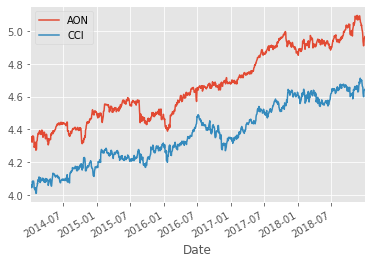

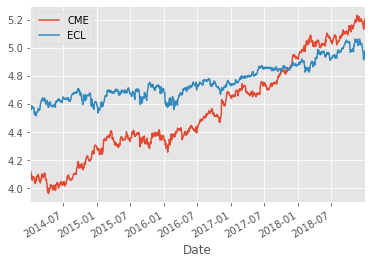

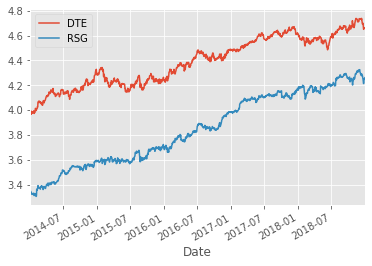

In [0]:
#plot the price movement of the selected pairs

# AON vs CCI
AON = np.log(df_prices['Adj. Close'].loc['AON'].loc['2014-01-01':'2018-12-31'])
CCI = np.log(df_prices['Adj. Close'].loc['CCI'].loc['2014-01-01':'2018-12-31'])
AC = pd.concat([AON,CCI],axis=1)
AC.columns = ['AON','CCI']
AC.plot()

# CME vs ECL
CME = np.log(df_prices['Adj. Close'].loc['CME'].loc['2014-01-01':'2018-12-31'])
ECL = np.log(df_prices['Adj. Close'].loc['ECL'].loc['2014-01-01':'2018-12-31'])
CE = pd.concat([CME,ECL],axis=1)
CE.columns = ['CME','ECL']
CE.plot()

# DTE vs RSG
DTE = np.log(df_prices['Adj. Close'].loc['DTE'].loc['2014-01-01':'2018-12-31'])
RSG = np.log(df_prices['Adj. Close'].loc['RSG'].loc['2014-01-01':'2018-12-31'])
DR = pd.concat([DTE,RSG],axis=1)
DR.columns = ['DTE','RSG']
DR.plot()

## Pairs Trading Strategy

In [0]:
class statarb(object):
    #setting the strategy's attributes
    def __init__(self,df1,df2,ma,floor,ceiling,beta_lookback,start,end,
                 enter_long=0,enter_short=0,exit_zscore=0):
        self.df1 = df1
        self.df2 = df2
        self.df = pd.DataFrame(index=df1.index) 
        self.ma = ma
        self.floor = floor
        self.ceiling = ceiling
        self.enter_long = enter_long
        self.enter_short = enter_short
        self.exit_zscore = exit_zscore
        self.beta_lookback = beta_lookback
        self.start = start
        self.end = end
    
    #creating the price spread
    def create_spread(self):
        self.df['X'] = self.df1['Close']
        self.df['Y'] = self.df2['Close']
        
        #calculating the beta of the pairs
        self.df['cov'] = self.df['X'].rolling(self.beta_lookback).cov(self.df['Y'])
        self.df['var'] = self.df['Y'].rolling(self.beta_lookback).var()
        self.df['beta'] = self.df['cov'] / self.df['var']
        
        #setting the hedge ratio
        self.df['Hedge Ratio'] = self.df['beta']
        
        #calculating the spread
        self.df['Spread'] = self.df['X'] - (self.df['Hedge Ratio'] * self.df['Y'])
        
        return self.df
    
    
    #creating the signals
    def generate_signals(self):
        
        #creating the Z-Score
        self.df['Z-Score'] = (self.df['Spread'] - self.df['Spread'].rolling(window=self.ma).mean())\
        /self.df['Spread'].rolling(window=self.ma).std()
        
        #creating buy and sell signals
        self.df['Long Signal'] = (self.df['Z-Score']<=self.floor)*1.0 #buy the spread
        self.df['Short Signal'] = (self.df['Z-Score']>=self.ceiling)*1.0 #short the spread
        self.df['Exit'] = (self.df['Z-Score']<=self.exit_zscore)*1.0 #exit position
        
        #tracking the positions
        self.df['In Long'] = 0.0
        self.df['In Short'] = 0.0
        
        #signal generator
        for i,value in enumerate(self.df.iterrows()):
            #longs
            if value[1]['Long Signal'] == 1.0:
                self.enter_long = 1
            #shorts
            if value[1]['Short Signal'] == 1.0:
                self.enter_short = 1
            #exit
            if value[1]['Exit'] == 1.0:
                self.enter_long = 0
                self.enter_short = 0
                
            self.df.iloc[i]['In Long'] = self.enter_long
            self.df.iloc[i]['In Short'] = self.enter_short
            
        return self.df
    
    
    #creating the strategy returns
    def create_returns(self,allocation):
        self.allocation = allocation
        
        #creating the portfolio values
        self.portfolio = pd.DataFrame(index=self.df.index)
        self.portfolio['Positions'] = self.df['Long Signal'] - self.df['Short Signal']
        self.portfolio['X'] = -1.0 * self.df['X'] * self.portfolio['Positions']
        self.portfolio['Y'] = self.df['Y'] * self.portfolio['Positions']
        self.portfolio['Total'] = self.portfolio['X'] + self.portfolio['Y']
        
        #creating the portfolio returns
        self.portfolio['Returns'] = self.portfolio['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0,inplace=True)
        self.portfolio['Returns'].replace([np.inf,-np.inf],0.0,inplace=True)
        self.portfolio['Returns'].replace(-1.0,0.0,inplace=True)
        self.portfolio['Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Portfolio Value'] = (self.allocation*self.portfolio['Returns'])
        self.portfolio['Daily Returns'] = self.portfolio['Portfolio Value'].pct_change()
            
        return

## Backtesting - (AON vs CCI)

AON vs CCI Performance Results
Sharpe Ratio : 1.55
Total Return : 91.83%
Final Portfolio Value : $191833.73


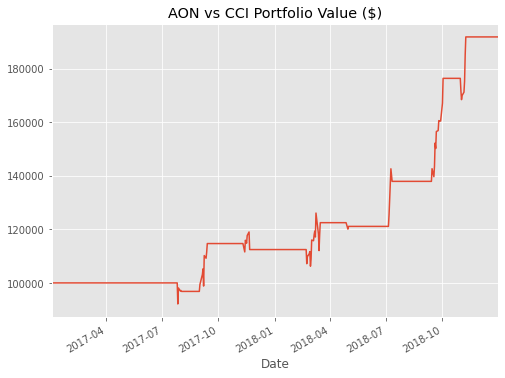

In [0]:
AON = df_prices[['Adj. Close']].loc['AON'].loc['2017-01-01':'2018-12-31']
AON.columns=['Close']
CCI = df_prices[['Adj. Close']].loc['CCI'].loc['2017-01-01':'2018-12-31']
CCI.columns=['Close']

from datetime import datetime
start = datetime(2017,1,1)
end = datetime(2018,12,31)

ma = 35
floor = -2
ceiling = 2
beta_lookback = 90

AON_CCI = statarb(AON,CCI,ma,floor,ceiling,beta_lookback,start,end)
AON_CCI.create_spread()
AON_CCI.generate_signals()
statarb.create_returns(AON_CCI,100000)

plt.figure(figsize = (8,6))
AON_CCI.portfolio['Portfolio Value'].plot(title = 'AON vs CCI Portfolio Value ($)')

sharpe = (AON_CCI.portfolio['Daily Returns'].mean()/AON_CCI.portfolio['Daily Returns'].std()) * np.sqrt(252)
total_return = ((AON_CCI.portfolio['Returns'].iloc[-1]) - 1) * 100
port_value = AON_CCI.portfolio['Portfolio Value'].iloc[-1]

print('AON vs CCI Performance Results')
print('Sharpe Ratio : ' + str(round(sharpe,2)))
print('Total Return : ' + str(round(total_return,2)) + '%')
print('Final Portfolio Value : ' + '$' + str(round(port_value,2)))

## Backtesting - (CME vs ECL)

CME vs ECL Performance Results
Sharpe Ratio : 0.96
Total Return : 230.69%
Final Portfolio Value : $330687.76


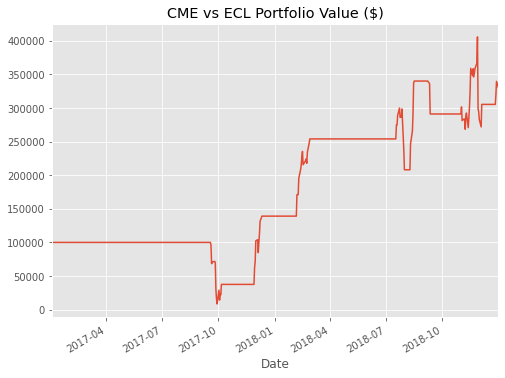

In [0]:
CME = df_prices[['Adj. Close']].loc['CME'].loc['2017-01-01':'2018-12-31']
CME.columns=['Close']
ECL = df_prices[['Adj. Close']].loc['ECL'].loc['2017-01-01':'2018-12-31']
ECL.columns=['Close']

from datetime import datetime
start = datetime(2017,1,1)
end = datetime(2018,12,31)

ma = 35
floor = -2
ceiling = 2
beta_lookback = 90

CME_ECL = statarb(CME,ECL,ma,floor,ceiling,beta_lookback,start,end)
CME_ECL.create_spread()
CME_ECL.generate_signals()
statarb.create_returns(CME_ECL,100000)


plt.figure(figsize = (8,6))
CME_ECL.portfolio['Portfolio Value'].plot(title = 'CME vs ECL Portfolio Value ($)')

sharpe = (CME_ECL.portfolio['Daily Returns'].mean()/CME_ECL.portfolio['Daily Returns'].std()) * np.sqrt(252)
total_return = ((CME_ECL.portfolio['Returns'].iloc[-1]) - 1) * 100
port_value = CME_ECL.portfolio['Portfolio Value'].iloc[-1]

print('CME vs ECL Performance Results')
print('Sharpe Ratio : ' + str(round(sharpe,2)))
print('Total Return : ' + str(round(total_return,2)) + '%')
print('Final Portfolio Value : ' + '$' + str(round(port_value,2)))

## Backtesting - (DTE vs RSG)

DTE vs RSG Performance Results
Sharpe Ratio : 1.23
Total Return : 65.98%
Final Portfolio Value : $165976.83


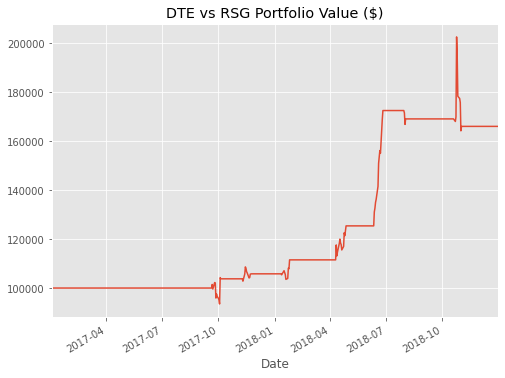

In [0]:
# DTE vs RSG
DTE = df_prices[['Adj. Close']].loc['DTE'].loc['2017-01-01':'2018-12-31']
DTE.columns=['Close']
RSG = df_prices[['Adj. Close']].loc['RSG'].loc['2017-01-01':'2018-12-31']
RSG.columns=['Close']

from datetime import datetime
start = datetime(2017,1,1)
end = datetime(2018,12,31)

ma = 35
floor = -2
ceiling = 2
beta_lookback = 90

DTE_RSG = statarb(DTE,RSG,ma,floor,ceiling,beta_lookback,start,end)
DTE_RSG.create_spread()
DTE_RSG.generate_signals()
statarb.create_returns(DTE_RSG,100000)


plt.figure(figsize = (8,6))
DTE_RSG.portfolio['Portfolio Value'].plot(title = 'DTE vs RSG Portfolio Value ($)')

sharpe = (DTE_RSG.portfolio['Daily Returns'].mean()/DTE_RSG.portfolio['Daily Returns'].std()) * np.sqrt(252)
total_return = ((DTE_RSG.portfolio['Returns'].iloc[-1]) - 1) * 100
port_value = DTE_RSG.portfolio['Portfolio Value'].iloc[-1]

print('DTE vs RSG Performance Results')
print('Sharpe Ratio : ' + str(round(sharpe,2)))
print('Total Return : ' + str(round(total_return,2)) + '%')
print('Final Portfolio Value : ' + '$' + str(round(port_value,2)))

## Resources
###### https://medium.com/@SimFin_official/a-next-generation-api-for-financial-data-5eaf87c991c7
###### https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80
###### https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
###### https://blog.quantinsti.com/k-means-clustering-pair-selection-python/
###### https://kidquant.com/project/pairs-trading-strategies-in-python/

## The End